# 分析の準備

## パッケージの読み込み

In [1]:
import arviz
import pystan
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Meiryo'
import seaborn as sns

# データの読み込みと図示

## 分析対象のデータ

In [3]:
germination_dat = pd.read_csv('3-9-1-germination.csv')
germination_dat.head(n=3)

,germination,size,solar,nutrition
0,0,10,shade,1
1,0,10,shade,1
2,0,10,shade,1


## データの要約

In [4]:
germination_dat.describe(include='all')

,germination,size,solar,nutrition
count,100.000000,100.0,100,100.000000
unique,NaN,NaN,2,NaN
top,NaN,NaN,shade,NaN
freq,NaN,NaN,50,NaN
mean,2.830000,10.0,NaN,5.500000
std,3.417291,0.0,NaN,2.886751
min,0.000000,10.0,NaN,1.000000
25%,0.000000,10.0,NaN,3.000000
50%,1.000000,10.0,NaN,5.500000
75%,4.000000,10.0,NaN,8.000000


## 図示

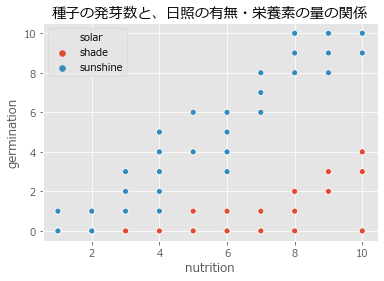

In [6]:
plt.figure()
sns.scatterplot(x='nutrition',
                y='germination',
                data=germination_dat,
                hue='solar')
plt.title('種子の発芽数と、日照の有無・栄養素の量の関係')
plt.show()

# brmsによるロジスティック回帰モデルの推定

# brmsを用いない実装の方法
## 参考：ダミー変数の作成

In [7]:
solar_dummy = pd.get_dummies(germination_dat['solar'], drop_first=True)

## 参考：データの作成

In [8]:
data_list_1 = dict(N=len(germination_dat),
                   germination=germination_dat['germination'],
                   binom_size=germination_dat['size'],
                   solar=solar_dummy.values.flatten(),
                   nutrition=germination_dat['nutrition'])
data_list_1

{'N': 100,
 'germination': 0      0
 1      0
 2      0
 3      0
 4      0
       ..
 95     9
 96    10
 97    10
 98     9
 99    10
 Name: germination, Length: 100, dtype: int64,
 'binom_size': 0     10
 1     10
 2     10
 3     10
 4     10
       ..
 95    10
 96    10
 97    10
 98    10
 99    10
 Name: size, Length: 100, dtype: int64,
 'solar': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8),
 'nutrition': 0      1
 1      1
 2      1
 3      1
 4      1
       ..
 95    10
 96    10
 97    10
 98    10
 99    10
 Name: nutrition, Length: 100, dtype: int64}

## 参考：自分でStanコードを実装

In [9]:
# stanコードの記述
stan_code = '''
data {
  int N;                   // サンプルサイズ
  int germination[N];      // 発芽数
  int binom_size[N];       // 二項分布の試行回数
  vector[N] solar;         // 1：日照あり
  vector[N] nutrition;     // 栄養量
}

parameters {
  real Intercept;          // 切片
  real b_solar;            // 係数(日照の有無)
  real b_nutrition;        // 係数(栄養量)
}

model {
  vector[N] prob = Intercept + b_solar*solar + b_nutrition*nutrition;
  germination ~ binomial_logit(binom_size, prob);
}

'''

# モデルのコンパイル
stan_model = pystan.StanModel(model_code=stan_code)

# サンプリング
glm_binom_stan = stan_model.sampling(data=data_list_1, seed=1, n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7f435734f42e9eb781e9bdcad6eac2bc NOW.


## 参考：結果の表示

In [10]:
print(glm_binom_stan.stansummary(probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_7f435734f42e9eb781e9bdcad6eac2bc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
Intercept    -8.03    0.02   0.51  -9.09   -8.0  -7.07    701    1.0
b_solar       4.05  9.9e-3   0.29    3.5   4.04   4.64    862    1.0
b_nutrition   0.72  1.9e-3   0.05   0.62   0.72   0.83    814    1.0
lp__        -303.2    0.03    1.2 -306.4 -302.9 -301.8   1175    1.0

Samples were drawn using NUTS at Mon Aug 31 08:40:53 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


# 推定されたモデルの解釈

## 係数の解釈

### 説明変数を作る

In [12]:
newdata_1 = np.matrix([[0, 2, 10],
                       [1, 2, 10],
                       [1, 3, 10]])

### 補足：係数行列を作る

In [13]:
# MCMCサンプルの抽出
mcmc_sample = glm_binom_stan.extract()

# 係数行列を作る
newdata_1_b = np.matrix